# https://www.kaggle.com/c/tt-GameLevel/data

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('train.csv')
df.head()

,Unnamed: 0,player_0,player_1,player_2,player_3,player_4,level_0,level_1,level_2,level_3,level_4,level_5,age,duration_ms,# tries,target
0,5204,0.025087,0.029495,3.361538e-06,0.007414,1.915486,0.002375,0.472284,0.021519,0.503860,11.0,1.0,15.0,215793.8,15,5
1,5175,0.024538,0.016962,2.842308e-06,0.004231,1.967912,0.001115,0.541616,0.005808,0.557895,NaN,0.0,20.0,271493.0,1,8
2,638,0.018192,0.017910,0.000000e+00,0.003359,1.953176,0.001296,0.456985,0.016872,0.596491,6.0,1.0,21.0,240264.0,6,3
3,6733,0.020673,0.020808,1.780798e-02,0.006423,1.998824,0.001202,0.507592,0.009712,0.615789,9.0,1.0,17.0,277560.5,4,8
4,2706,0.026192,0.032269,3.923077e-08,0.001815,2.108529,0.001269,0.489113,0.024154,0.410526,NaN,0.0,15.0,260773.0,1,9


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7551 entries, 0 to 7550
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   7551 non-null   int64  
 1   player_0     7551 non-null   float64
 2   player_1     7551 non-null   float64
 3   player_2     7551 non-null   float64
 4   player_3     7551 non-null   float64
 5   player_4     7551 non-null   float64
 6   level_0      7077 non-null   float64
 7   level_1      7043 non-null   float64
 8   level_2      6791 non-null   float64
 9   level_3      7277 non-null   float64
 10  level_4      6732 non-null   float64
 11  level_5      6967 non-null   float64
 12  age          5300 non-null   float64
 13  duration_ms  7551 non-null   float64
 14  # tries      7551 non-null   int64  
 15  target       7551 non-null   int64  
dtypes: float64(13), int64(3)
memory usage: 944.0 KB


- player_XXX - anonymized player metadata (how much overall time player spent in the game? how much points player collected? etc.)
- level_XXX - anonymized gameplay metadata (how much points player collected during this level? how much HP player lost during this level? etc.)
- age - age of the player (years)
- duration_ms - duration of the last (successful) try
- tries - number of tries it took to finish this level

In [4]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

def fill_missed_values(original_data):
    
    new_data = original_data.copy()

    cols_with_missing = (col for col in new_data.columns 
                                     if new_data[col].isnull().any())
    for col in cols_with_missing:
        new_data[col + '_was_missing'] = new_data[col].isnull()
    real_columns = new_data.columns
    
    imputer = IterativeImputer(max_iter=10, initial_strategy='mean', random_state=42)
    new_data = pd.DataFrame(imputer.fit_transform(new_data))
    new_data.columns = real_columns
    
    return new_data

In [5]:
from sklearn.preprocessing import StandardScaler

df.duration_ms = StandardScaler().fit_transform(df.duration_ms.values.reshape(-1,1))
df = fill_missed_values(df)

features = ['level_4', 'level_5', 'age', '# tries', 'target', 'level_0_was_missing',
            'level_1_was_missing', 'level_2_was_missing', 'level_3_was_missing', 
            'level_4_was_missing', 'level_5_was_missing', 'age_was_missing']

for feature in features:
    df[feature] = df[feature].astype(np.int64)

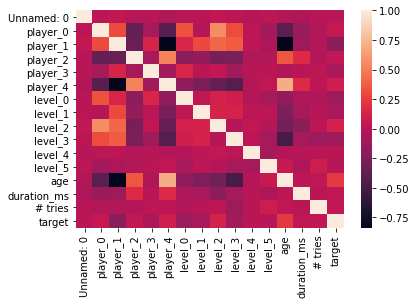

In [6]:
sns.heatmap(df.iloc[:, :16].corr())

# Modeling

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix

In [8]:
X = df.drop(['Unnamed: 0', 'target'], axis=1)
y = df.target

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

## MLP 2b

In [26]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(activation='relu', solver='adam', alpha=1e-4, max_iter=500, random_state=42)
mlp_params = {
    'hidden_layer_sizes': [(100,), (50, 10,)]
}
mlp_clf = GridSearchCV(mlp, param_grid=mlp_params, n_jobs=-1, scoring='f1_macro', cv=5)
mlp_clf

GridSearchCV(cv=5, error_score=nan,
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_fun=15000,
                                     max_iter=500, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state=42, shuffle=True,
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'hi

In [27]:
%%time
mlp_clf.fit(X_train, y_train)
y_pred_mlp = mlp_clf.predict(X_test)

CPU times: user 21.2 s, sys: 15.5 s, total: 36.7 s
Wall time: 1min 29s


0.31605812481979434


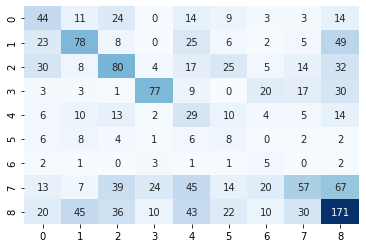

In [28]:
print(f1_score(y_test, y_pred_mlp, average='macro'))
sns.heatmap(confusion_matrix(y_pred_mlp, y_test), annot=True, fmt="d", cmap=plt.cm.Blues, cbar=False)

## DTC, RFC 3 

In [13]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(random_state=42)
dtc_params = {
    'max_depth': [3, 5, 7, 10, 15, 20]
}
dtc_clf = GridSearchCV(dtc, param_grid=dtc_params, n_jobs=-1, scoring='f1_macro', cv=5)
dtc_clf

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=42,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 10, 15, 20]},
             pre_dis

In [14]:
%%time
dtc_clf.fit(X_train, y_train)
y_pred_dtc = dtc_clf.predict(X_test)

CPU times: user 188 ms, sys: 10.3 ms, total: 199 ms
Wall time: 1.59 s


0.32367633185869077


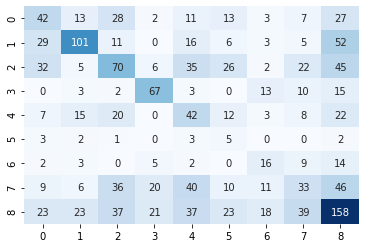

In [15]:
print(f1_score(y_test, y_pred_dtc, average='macro'))
sns.heatmap(confusion_matrix(y_pred_dtc, y_test), annot=True, fmt="d", cmap=plt.cm.Blues, cbar=False)

In [16]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state=42)
rfc_params = {
    'n_estimators': [260, 280],
    'max_depth': [3, 20]
}
rfc_clf = GridSearchCV(rfc, param_grid=rfc_params, n_jobs=-1, scoring='f1_macro', cv=5)
rfc_clf

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                                  

In [17]:
%%time
rfc_clf.fit(X_train, y_train)
y_pred_rfc = rfc_clf.predict(X_test)

CPU times: user 5.25 s, sys: 120 ms, total: 5.37 s
Wall time: 43.4 s


criterion=gini
 0.3993341770298876


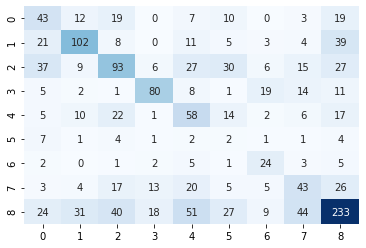

In [18]:
print('criterion=gini\n', f1_score(y_test, y_pred_rfc, average='macro'))
sns.heatmap(confusion_matrix(y_pred_rfc, y_test), annot=True, fmt="d", cmap=plt.cm.Blues, cbar=False)

In [19]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(criterion='entropy', random_state=42)
rfc_params = {
    'n_estimators': [260, 280],
    'max_depth': [3, 20]
}
rfc_clf = GridSearchCV(rfc, param_grid=rfc_params, n_jobs=-1, scoring='f1_macro', cv=5)
rfc_clf

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='entropy',
                                              max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, ra

In [20]:
%%time
rfc_clf.fit(X_train, y_train)
y_pred_rfc = rfc_clf.predict(X_test)

CPU times: user 13 s, sys: 137 ms, total: 13.2 s
Wall time: 1min 51s


criterion=entropy
 0.40125202138197974


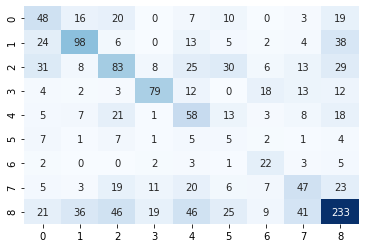

In [21]:
print('criterion=entropy\n', f1_score(y_test, y_pred_rfc, average='macro'))
sns.heatmap(confusion_matrix(y_pred_rfc, y_test), annot=True, fmt="d", cmap=plt.cm.Blues, cbar=False)

## SVC 4

In [22]:
from sklearn.svm import SVC
svc = SVC(kernel='rbf', random_state=42)
svc_params = {
    'C': [1, 100, 1000],
}
svc_clf = GridSearchCV(svc, param_grid=svc_params, n_jobs=-1, scoring='f1_macro', cv=5)
svc_clf

GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=42, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-1, param_grid={'C': [1, 100, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1_macro', verbose=0)

In [23]:
%%time
svc_clf.fit(X_train, y_train)
y_pred_svc = svc_clf.predict(X_test)

CPU times: user 11.4 s, sys: 67.7 ms, total: 11.5 s
Wall time: 1min 2s


0.2595154635792838


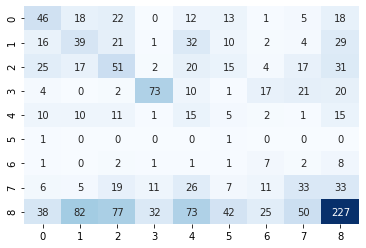

In [24]:
print(f1_score(y_test, y_pred_svc, average='macro'))
sns.heatmap(confusion_matrix(y_pred_svc, y_test), annot=True, fmt="d", cmap=plt.cm.Blues, cbar=False)

In [25]:
svc_clf.best_estimator_

SVC(C=1000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)